In [ ]:
import sys
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers



import numpy as np
import pandas as pd
import os


np.random.seed(42)
tf.random.set_seed(42)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

tf.__version__


'2.14.0'

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file(fname='cats_and_dogs_filterted.zip',
                                  origin=_URL,
                                  extract=True
                                  )

68606236/68606236 [==============================] - 0s 0us/step


In [ ]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')


In [ ]:
total_tr_cl = len(os.listdir(train_dir))
total_val_cl= len(os.listdir(val_dir))

print("Number of classes (tr):", total_tr_cl)
print("Number of classes (val) :", total_val_cl)

Number of classes (tr): 2
Number of classes (val) : 2


In [ ]:
BATCH_SIZE = 128
IMG_SHAPE  = 150

In [ ]:
train_image_generator = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [ ]:
total_tr=2000
total_val=1000


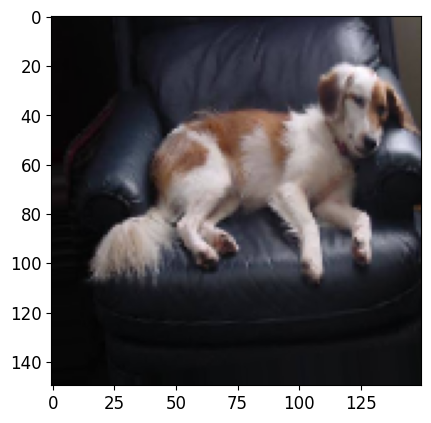

In [ ]:
plt.imshow(   train_data_gen[0][0][0]   )


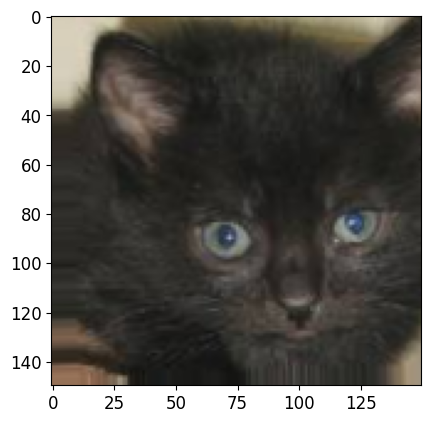

In [ ]:
plt.imshow(   train_data_gen[0][0][1]   )


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='LeakyReLU', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='LeakyReLU',
                           #kernel_regularizer=regularizers.l2(0.0001)
                           ),
    tf.keras.layers.Dense(2)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
EPOCHS = 5
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_tr / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
   # callbacks=[lr_schedule]
    )


Epoch 1/5
16/16 [==============================] - 127s 8s/step - loss: 0.6610 - accuracy: 0.6090 - val_loss: 0.7327 - val_accuracy: 0.5510
Epoch 2/5
16/16 [==============================] - 122s 8s/step - loss: 0.6442 - accuracy: 0.6260 - val_loss: 0.6218 - val_accuracy: 0.6560
Epoch 3/5
16/16 [==============================] - 118s 7s/step - loss: 0.6298 - accuracy: 0.6455 - val_loss: 0.6071 - val_accuracy: 0.6610
Epoch 4/5
16/16 [==============================] - 119s 7s/step - loss: 0.6164 - accuracy: 0.6690 - val_loss: 0.6290 - val_accuracy: 0.6370
Epoch 5/5
16/16 [==============================] - 123s 8s/step - loss: 0.6002 - accuracy: 0.6830 - val_loss: 0.5770 - val_accuracy: 0.6920


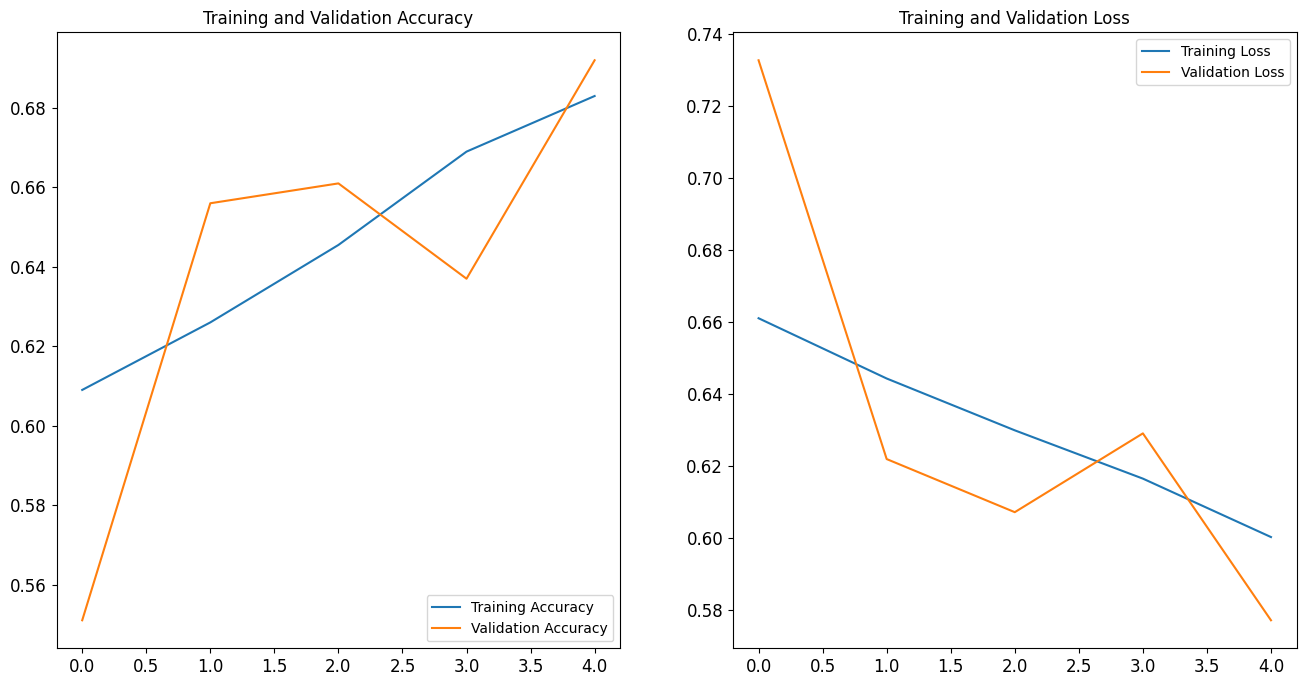

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()